In [1]:
import pyspedas
from pytplot import tplot, get_data
from pyspedas import tinterp
from pyspedas.analysis.tvectot import tvectot
import matplotlib.pyplot as plt

import xarray as xr
import polars as pl

import scipy.stats
import dcor

import astropy.units as u   

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
from datetimerange import DateTimeRange
from numpy import timedelta64
from datetime import datetime, timedelta

In [3]:
start = '2019-04-06'
end = '2019-04-09'


In [4]:
timerange = DateTimeRange(start, end)
dt = timedelta(days=2)
timerange_earth = timerange + dt

In [5]:
def validate(timerange):
    if isinstance(timerange, DateTimeRange):
        return [timerange.get_start_time_str(), timerange.get_end_time_str()]

## Get velocity

In [6]:
psp_spi_vars = pyspedas.psp.spi(trange=validate(timerange), time_clip=True)
swe_vars = pyspedas.ace.swe(trange=validate(timerange_earth), datatype = 'h0')

29-Jan-24 13:05:44: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2019/


Using LEVEL=L3


29-Jan-24 13:05:44: File is current: /Users/zijin/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_l3_mom_20190406_v04.cdf
29-Jan-24 13:05:44: File is current: /Users/zijin/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_l3_mom_20190407_v04.cdf
29-Jan-24 13:05:45: File is current: /Users/zijin/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2019/psp_swp_spi_sf00_l3_mom_20190408_v04.cdf
29-Jan-24 13:05:46: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/ace/swepam/level_2_cdaweb/swe_h0/2019/
29-Jan-24 13:05:46: File is current: /Users/zijin/data/ace/swepam/level_2_cdaweb/swe_h0/2019/ac_h0_swe_20190408_v11.cdf
29-Jan-24 13:05:47: File is current: /Users/zijin/data/ace/swepam/level_2_cdaweb/swe_h0/2019/ac_h0_swe_20190409_v11.cdf
29-Jan-24 13:05:47: File is current: /Users/zijin/data/ace/swepam/level_2_cdaweb/swe_h0/2019/ac_h0_swe_20190410_v11.cdf


In [20]:
r_psp = get_data('psp_spi_SUN_DIST', xarray=True)
r_psp = pl.DataFrame(r_psp.to_dataframe().reset_index())


In [40]:
km2au = u.km.to(u.AU)
r_earth = 1 * u.AU.to(u.km)
v_sw_slow = 250 * u.km / u.s
v_sw_fast = 600 * u.km / u.s

r_psp.with_columns(
    distance2sun = pl.col('psp_spi_SUN_DIST'),
    distance2earth = r_earth - pl.col('psp_spi_SUN_DIST')
).with_columns(
    dt2arrival_slow = pl.duration(seconds = pl.col('distance2earth') / v_sw_slow),
    dt2arrival_fast = pl.duration(seconds = pl.col('distance2earth') / v_sw_fast)
).with_columns(
    time2arrival_slow = pl.col('time') + pl.col('dt2arrival_slow'),
    time2arrival_fast = pl.col('time') + pl.col('dt2arrival_fast')
).with_columns(
    distance2sun = pl.col('distance2sun') * km2au,
    distance2earth = pl.col('distance2earth') * km2au
)

time,psp_spi_SUN_DIST,distance2sun,distance2earth,dt2arrival_slow,dt2arrival_fast,time2arrival_slow,time2arrival_fast
datetime[ns],f64,f64,f64,duration[μs],duration[μs],datetime[μs],datetime[μs]
2019-04-06 00:00:07.361029,2.5434e7,0.170019,0.829981,5d 17h 57m 33s,2d 9h 28m 58s,2019-04-11 17:57:40.361029,2019-04-08 09:29:05.361029
2019-04-06 00:00:14.351510,2.5435e7,0.17002,0.82998,5d 17h 57m 33s,2d 9h 28m 58s,2019-04-11 17:57:47.351510,2019-04-08 09:29:12.351510
2019-04-06 00:00:21.342050,2.5435e7,0.17002,0.82998,5d 17h 57m 32s,2d 9h 28m 58s,2019-04-11 17:57:53.342050,2019-04-08 09:29:19.342050
2019-04-06 00:00:28.332591,2.5435e7,0.170021,0.829979,5d 17h 57m 32s,2d 9h 28m 58s,2019-04-11 17:58:00.332591,2019-04-08 09:29:26.332591
2019-04-06 00:00:35.323131,2.5435e7,0.170022,0.829978,5d 17h 57m 32s,2d 9h 28m 58s,2019-04-11 17:58:07.323131,2019-04-08 09:29:33.323131
2019-04-06 00:00:42.313611,2.5435e7,0.170022,0.829978,5d 17h 57m 31s,2d 9h 28m 58s,2019-04-11 17:58:13.313611,2019-04-08 09:29:40.313611
2019-04-06 00:00:49.304152,2.5435e7,0.170023,0.829977,5d 17h 57m 31s,2d 9h 28m 58s,2019-04-11 17:58:20.304152,2019-04-08 09:29:47.304152
2019-04-06 00:00:56.294692,2.5435e7,0.170023,0.829977,5d 17h 57m 30s,2d 9h 28m 57s,2019-04-11 17:58:26.294692,2019-04-08 09:29:53.294692
2019-04-06 00:01:03.285233,2.5435e7,0.170024,0.829976,5d 17h 57m 30s,2d 9h 28m 57s,2019-04-11 17:58:33.285233,2019-04-08 09:30:00.285233


In [178]:
psp_arrival_time_slow = r_psp_earth / v_sw_slow

<xarray.DataArray 'psp_spi_SUN_DIST' (time: 37027)>
array([413877.92844503, 413877.61956999, 413877.31067029, ...,
       391053.48611238, 391052.66438815, 391051.84265053])
Coordinates:
  * time     (time) datetime64[ns] 2019-04-06T00:00:07.361029 ... 2019-04-08T...
Attributes:
    CDF:           {'VATT': {'CATDESC': 'Spacecraft Distance to the Sun', 'FI...
    data_att:      {'coord_sys': '', 'units': 'km', 'depend_1_units': 'km', '...
    plot_options:  {'xaxis_opt': {'axis_label': 'Time', 'crosshair': 'X', 'x_...

In [175]:
r_psp_earth

<xarray.DataArray 'psp_spi_SUN_DIST' (time: 37027)>
array([1.24163379e+08, 1.24163286e+08, 1.24163193e+08, ...,
       1.17316046e+08, 1.17315799e+08, 1.17315553e+08])
Coordinates:
  * time     (time) datetime64[ns] 2019-04-06T00:00:07.361029 ... 2019-04-08T...
Attributes:
    CDF:           {'VATT': {'CATDESC': 'Spacecraft Distance to the Sun', 'FI...
    data_att:      {'coord_sys': '', 'units': 'km', 'depend_1_units': 'km', '...
    plot_options:  {'xaxis_opt': {'axis_label': 'Time', 'crosshair': 'X', 'x_...

In [150]:
tvar = tvectot("psp_spi_VEL_RTN_SUN")
psp_ion_speed: xr.DataArray = get_data(tvar, xarray=True)

ace_ion_speed: xr.DataArray = get_data("Vp", xarray=True)

In [156]:
v1 = psp_ion_speed.dropna('time')
v2 = ace_ion_speed.dropna('time')

v1['time'] = v1['time'] + timedelta64(dt)
v1 = v1.interp_like(v2)
v1.shape == v2.shape

True

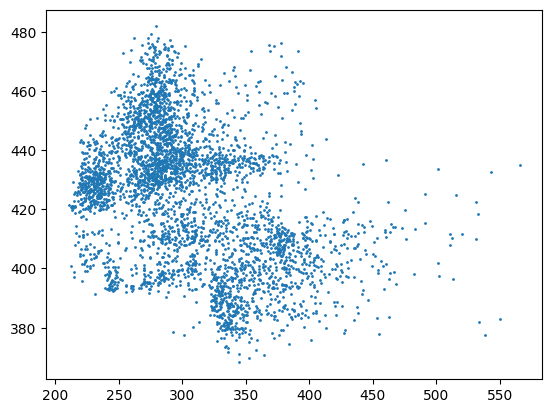

In [159]:
plt.scatter(v1, v2, s=1)

In [162]:
scipy.stats.pearsonr(v1, v2).statistic
dcor.distance_correlation(v1, v2)


0.4751159337791697

In [34]:
ace_ion_speed

<xarray.DataArray 'Vp' (time: 864)>
array([ 520.72,  517.02,  516.28,  514.83,  514.23,  511.74,  511.51,
        513.92,  528.33,  510.62,  521.24,  518.9 ,  506.36, -999.9 ,
        506.93,  517.98,  525.03,  523.32,  521.32,  521.98,  525.89,
        528.58,  523.24,  524.99,  526.78,  517.85,  511.2 ,  508.91,
        506.08,  519.67,  527.56,  526.8 ,  530.19,  529.09,  526.76,
        525.41,  526.25,  524.78,  524.98,  516.29,  508.49,  510.31,
        502.32,  503.62,  495.54,  493.53,  494.45,  493.14,  491.76,
        496.91,  492.53,  492.43,  502.16,  506.75,  513.49,  511.88,
        498.09,  492.75,  488.8 ,  480.81,  478.92,  480.08,  481.89,
        483.52,  488.3 ,  517.84,  513.12,  495.18,  486.7 ,  487.59,
        492.02,  489.42,  474.2 ,  489.88,  479.56,  483.25,  479.94,
        482.18,  475.22,  468.93,  468.26,  466.95,  467.15,  468.44,
        467.  ,  464.41,  462.14,  463.23,  465.79,  466.55,  467.34,
        472.34,  472.36,  467.9 ,  470.16,  464.12,  473.78,  477.88,
        479.3 ,  480.3 ,  473.14,  465.25,  463.96,  461.95,  465.84,
        469.93,  471.68,  475.68,  474.26,  464.34,  464.35,  465.09,
        469.99,  466.79,  460.61,  459.87,  460.24,  461.94,  465.63,
        467.62,  463.9 ,  469.23,  470.56,  461.88,  461.8 ,  459.67,
        457.79,  461.1 ,  465.22,  458.88,  459.5 ,  456.99,  462.77,
        456.98,  452.85,  453.86,  456.36,  457.44,  458.74,  463.45,
...
        452.27,  458.62,  474.37,  476.36,  467.43,  461.47,  467.7 ,
        467.01,  463.38,  466.67,  467.05,  474.61,  474.97,  453.35,
        448.53,  446.06,  463.11,  464.44,  449.11,  459.06,  459.79,
        446.83,  446.64,  444.66,  441.74,  442.02,  438.87,  438.69,
        445.03,  452.8 ,  456.41,  459.54,  442.53,  442.67,  443.96,
        443.91,  439.28,  437.85,  438.41,  443.75,  445.95,  452.39,
        433.57,  433.54,  434.73,  435.28,  434.81,  429.97,  430.18,
        431.6 ,  433.72,  431.21,  434.62,  434.65,  432.79,  434.46,
        426.95,  426.29,  428.67,  428.93,  430.37,  430.21,  432.14,
        433.07,  440.08,  441.53,  430.2 ,  428.6 ,  432.24,  424.35,
        422.93,  423.03,  426.12,  425.64,  423.66,  428.52,  431.68,
        427.33,  423.89,  423.2 ,  423.28,  431.6 ,  430.52,  430.25,
        435.75,  442.37,  442.88,  442.91,  429.51,  433.2 ,  431.33,
        439.78,  443.67,  447.14,  426.03,  408.84,  410.49,  405.05,
        401.  ,  401.88,  406.37,  404.3 ,  402.81,  411.98,  411.29,
        410.7 ,  405.8 ,  406.26,  401.46,  403.27,  397.97,  394.92,
        406.33,  398.68,  402.56,  403.04,  400.54,  399.72,  405.88,
        399.4 ,  394.66,  389.89,  384.31,  391.4 ,  384.04,  387.3 ,
        382.99,  390.31,  383.85,  385.43, -999.9 ,  380.07,  380.74,
        386.94,  390.33,  391.44], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2019-04-06 ... 2019-04-08T23:55:00
Attributes:
    CDF:           {'VATT': {'FIELDNAM': 'Solar Wind Proton Speed', 'VALIDMIN...
    data_att:      {'coord_sys': '', 'units': 'km/s', 'depend_1_units': 'km/s...
    plot_options:  {'xaxis_opt': {'axis_label': 'Time', 'crosshair': 'X', 'x_...